In [1]:
import pickle
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import umap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile as tf

In [2]:
exemplar_df = pd.read_csv("/Users/swarchol/Research/seal/data/exemplar-001/new/updated.csv")

In [3]:
feature_columns = ['DNA_6', 'ELANE', 'CD57', 'CD45',  'CD11B', 'SMA',
       'CD16',  'ECAD', 'FOXP3', 'NCAM', ]

In [4]:
# feature_matrix
feature_matrix = exemplar_df[feature_columns].to_numpy()
# log normalize
feature_matrix = np.log1p(feature_matrix)
# # feature_matrix
# # standardize
# feature_matrix = (feature_matrix - feature_matrix.mean(axis=0)) / feature_matrix.std(axis=0)
# # feature_matrix
# # normalize between 0 and 1 
# feature_matrix = (feature_matrix - feature_matrix.min(axis=0)) / (feature_matrix.max(axis=0) - feature_matrix.min(axis=0))
# # feature_matrix
# # n


/var/folders/ps/x7v31pds3gn4t11djwg0t03h0000gp/T/ipykernel_56406/2818083335.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='viridis',alpha=0.1)


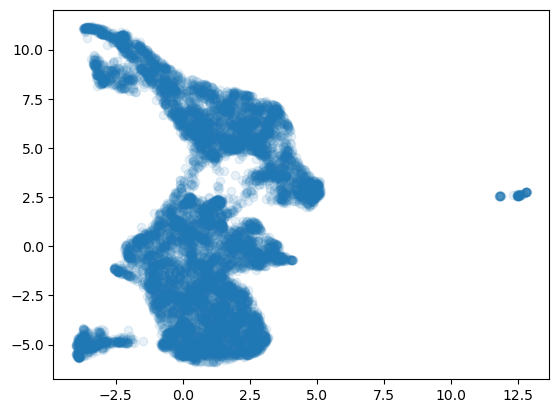

In [5]:
import umap
import matplotlib.pyplot as plt
# embedding
embedding = umap.UMAP(n_components=2, n_neighbors=50, min_dist=0.1, metric='cosine').fit_transform(feature_matrix)
plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='viridis',alpha=0.1)

/var/folders/ps/x7v31pds3gn4t11djwg0t03h0000gp/T/ipykernel_56406/892025830.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='viridis',alpha=0.1)


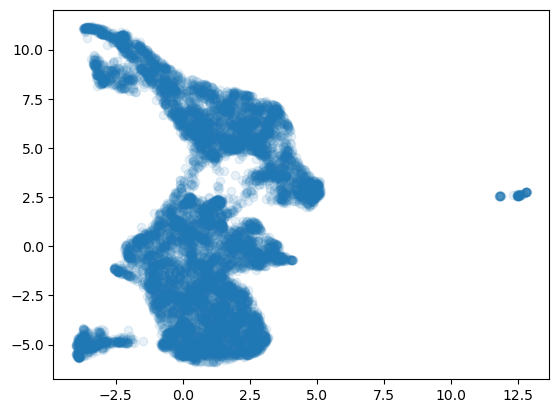

In [6]:
plt.scatter(embedding[:, 0], embedding[:, 1],  cmap='viridis',alpha=0.1)

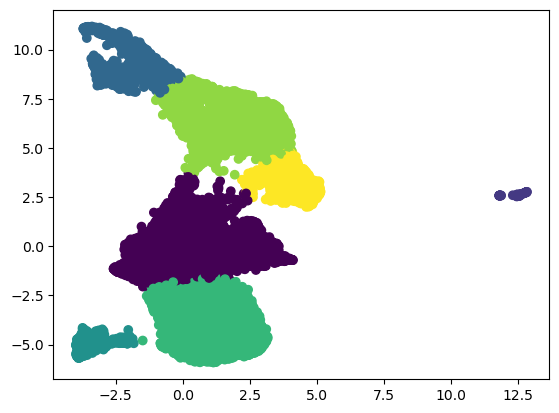

In [7]:
# try gmm
# spectral clustering
from sklearn.cluster import SpectralClustering
spectral = SpectralClustering(n_clusters=7, random_state=42).fit(embedding)
cluster_labels = spectral.labels_
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis')



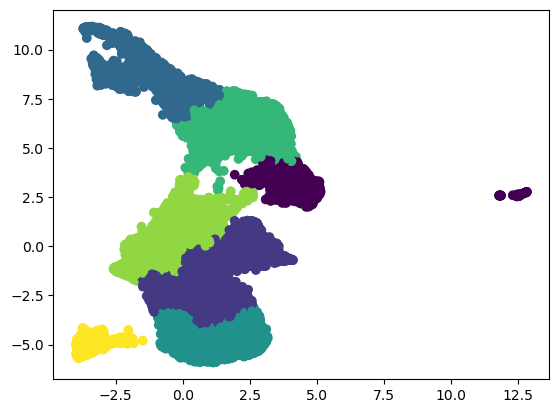

In [8]:
# agglomerative clustering
from sklearn.cluster import AgglomerativeClustering
agglomerative = AgglomerativeClustering(n_clusters=7
                                        ).fit(embedding)
cluster_labels = agglomerative.labels_
plt.scatter(embedding[:, 0], embedding[:, 1], c=cluster_labels, cmap='viridis')



In [9]:
x_range = exemplar_df["X_centroid"].min(), exemplar_df["X_centroid"].max()
y_range = exemplar_df["Y_centroid"].min(), exemplar_df["Y_centroid"].max()
# Scale umap_result to x_range and y_range
umap_result = (embedding - embedding.min(axis=0)) / (embedding.max(axis=0) - embedding.min(axis=0))
umap_result[:, 0] = 0.9* umap_result[:, 0] * (x_range[1] - x_range[0]) + x_range[0]
umap_result[:, 1] = 0.9 *umap_result[:, 1] * (y_range[1] - y_range[0]) + y_range[0]


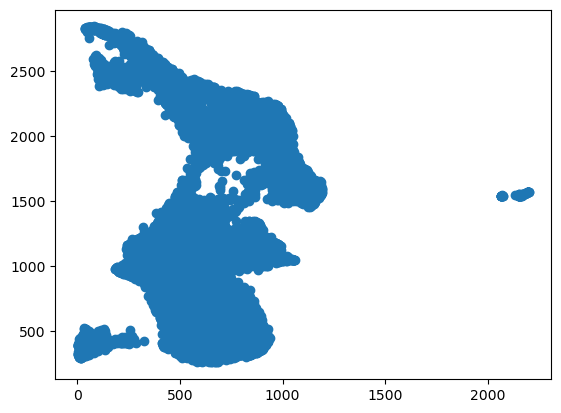

In [10]:
plt.scatter(umap_result[:, 0], umap_result[:, 1])

exemplar_df['UMAP_X'] = umap_result[:, 0]
exemplar_df['UMAP_Y'] = umap_result[:, 1]

exemplar_df.to_csv("/Users/swarchol/Documents/exemplar_df.csv", index=False)

In [11]:
image_path = "/Users/swarchol/Research/seal/data/exemplar-001/registration/exemplar-001.ome.tif"
csv_path = "/Users/swarchol/Documents/exemplar_df.csv"
dest_path = "/Users/swarchol/Documents/exemplar_df"
segmentation_path = r"/Users/swarchol/Research/seal/data/exemplar-001/segmentation/unmicst-exemplar-001/cell.ome.tif"

In [12]:
import cellcutter
import cellcutter.cli
from tqdm import tqdm
import tifffile as tf
import os
import shutil
import zarr
from zarr import Blosc

img = (tf.TiffFile(image_path, is_ome=False))
if os.path.exists(dest_path):
    shutil.rmtree(dest_path)
for i in tqdm(range(len(img.pages))):
    sample_path = f"{dest_path}/channel_{i}"
    args = [image_path,
    segmentation_path,
    csv_path,
    sample_path,
    "-p", "8",  # Number of processes
        "--channels", (str(i+1)),  # Specific channels to include
        "--cache-size", str(1024 * 1024 * 1024 * 4),  # Cache size
    ]
    cellcutter.cli.cut(args)
    
    
# Now Create the Mask
sample_path = f"{dest_path}/mask"
args = [image_path,
segmentation_path,
csv_path,
sample_path,
"-p", "8",  # Number of processes
    "--channels", (str(i+1)),  # Specific channels to include
    "--cache-size", str(1024 * 1024 * 1024 * 4),  # Cache size
    "--mask-cells"
    
]
cellcutter.cli.cut(args)
# Remove the mask directory but keep mask_mask
import shutil
shutil.rmtree(f"{dest_path}/mask")
shutil.move(f"{dest_path}/mask_mask", f"{dest_path}/mask")
paths_list = [f"{dest_path}/channel_{i}" for i in range(len(img.pages))]
zarr_list = [zarr.open(path) for path in paths_list]
# remove existing combined zarr
if os.path.exists(dest_path + "/combined"):
    shutil.rmtree(dest_path + "/combined")
combined_store = zarr.DirectoryStore(dest_path + "/combined")# [r.chunks for r in zarr_list]
combined = zarr.create(
            store=combined_store,
            overwrite=True,
            shape=(len(zarr_list), zarr_list[0].shape[1],zarr_list[0].shape[2],zarr_list[0].shape[3]),
            dtype=zarr_list[0].dtype,
            compressor=Blosc(cname="zstd", clevel=2, shuffle=Blosc.SHUFFLE)        )

for i in tqdm(range(len(zarr_list))):
    combined[i,:,:,:] = zarr_list[i][0]


# Remove the individual channel zarrs
for path in paths_list:
    shutil.rmtree(path)

  0%|          | 0/12 [00:00<?, ?it/s]MainProcess 2025-04-09 19:49:38,274 INFO: Namespace(p=8, z=False, force=False, window_size=None, mask_cells=False, channels=[1], cache_size=4294967296, chunk_size=32, cells_per_chunk=None, IMAGE='/Users/swarchol/Research/seal/data/exemplar-001/registration/exemplar-001.ome.tif', SEGMENTATION_MASK='/Users/swarchol/Research/seal/data/exemplar-001/segmentation/unmicst-exemplar-001/cell.ome.tif', CELL_DATA='/Users/swarchol/Documents/exemplar_df.csv', DESTINATION='/Users/swarchol/Documents/exemplar_df/channel_0')
MainProcess 2025-04-09 19:49:38,320 INFO: Loading cell data
MainProcess 2025-04-09 19:49:38,343 INFO: Check if all cell IDs from the CSV are represented in the segmentation mask
MainProcess 2025-04-09 19:49:38,363 INFO: Remove cells from segmentation mask that are not present in the CSV
MainProcess 2025-04-09 19:49:38,394 INFO: Finding window size
MainProcess 2025-04-09 19:49:38,660 INFO: Window size automatically set to (39, 39)
MainProcess 20

In [13]:
# Generate New Images
TILE_SIZE = 1024
DOWNSCALE_FACTOR = 2
MAX_PYRAMID_IMG_SIZE = 1024
from scipy.spatial import cKDTree
from tqdm import tqdm
import tifffile
from loguru import logger
import math
import tempfile
import shutil

image_path = "/Users/swarchol/Research/seal/data/exemplar-001/registration/exemplar-001.ome.tif"
csv_path = "/Users/swarchol/Documents/exemplar_df.csv"
dest_path = "/Users/swarchol/Documents/exemplar_df"
# segmentation_path = 


SEGMENTATION_PATH = r"/Users/swarchol/Research/seal/data/exemplar-001/segmentation/unmicst-exemplar-001/cell.ome.tif"
CSV_PATH = "/Users/swarchol/Documents/exemplar_df.csv"
IMAGE_PATH = "/Users/swarchol/Research/seal/data/exemplar-001/registration/exemplar-001.ome.tif"
IM_STORE = zarr.DirectoryStore('~/imstor')
SEG_STORE = zarr.DirectoryStore('~/segstor')
CUT_SEG_CELLS_PATH = "/Users/swarchol/Documents/exemplar_df/mask"
CUT_CELLS_PATH = "/Users/swarchol/Documents/exemplar_df/combined"
OUTPUT_TIFF_PATH = "/Users/swarchol/Documents/exemplar_df/tiled.ome.tif"
OUTPUT_SEGMENTATION_PATH = "/Users/swarchol/Documents/exemplar_df/tiled-mask.ome.tif"
CSV_WRITE_PATH = "/Users/swarchol/Documents/exemplar_df.csv"


# %%




def create_non_occlusive_zarr(im_zarr_tiled, seg_zarr_tiled, cut_cells, cut_masks, csv_df):
    # Create list of all indices of cells in cut_cells
    cell_indices = np.arange(cut_masks.shape[0])
    np.random.seed(0)
    np.random.shuffle(cell_indices)
    
    # Create cell ID lookup dictionary for faster access
    cell_id_dict = dict(zip(csv_df["CellID"], range(len(csv_df))))
    
    # For Jupyter compatibility, use sequential processing instead of multiprocessing
    for z in tqdm(range(len(im_zarr_tiled))):
        height, width = im_zarr_tiled[z].shape[-2:]
        scale_factor = 2 ** z

        # Work with NumPy arrays in memory for speed
        seg_level_data = np.zeros((height, width), dtype=np.uint32)
        image_level_data = np.zeros((im_zarr_tiled[z].shape[0], height, width), dtype=np.uint16)
        binary_mask = np.zeros((height, width), dtype=np.uint8)
        
        valid_cells = []
        valid_locations = []
        
        print(f'Finding valid cell placements for level {z}')
        # First pass - determine valid cell placements
        for cell_index in tqdm(cell_indices):
            if cell_index not in cell_id_dict:
                continue
            
            idx = cell_id_dict[cell_index]
            cell_row = csv_df.iloc[idx]
            cell_location = cell_row[["UMAP_X", "UMAP_Y"]].values.flatten()
            
            cell_center_offset = (cut_masks.shape[-2] // 2, cut_masks.shape[-1] // 2)
            cell_location = ((cell_location / scale_factor) - cell_center_offset).astype(int)
            cell_location = np.maximum(cell_location, 0)

            cell_x_range = min(cell_location[0] + cut_masks.shape[-2], width)
            cell_y_range = min(cell_location[1] + cut_masks.shape[-1], height)

            cell_slice_x = slice(cell_location[0], cell_x_range)
            cell_slice_y = slice(cell_location[1], cell_y_range)
            cut_cell_slice_x = slice(0, cell_x_range - cell_location[0])
            cut_cell_slice_y = slice(0, cell_y_range - cell_location[1])

            # Read the mask
            mask = cut_masks[cell_index, cut_cell_slice_y, cut_cell_slice_x]
            
            # Check overlap
            if np.any((binary_mask[cell_slice_y, cell_slice_x] + mask) > 1):
                continue
                
            # Update the binary mask
            binary_mask[cell_slice_y, cell_slice_x] += mask
            
            # Store cell info
            valid_cells.append(cell_index)
            valid_locations.append((cell_row["CellID"], cell_slice_y, cell_slice_x, 
                                  cut_cell_slice_y, cut_cell_slice_x))
        
        # Optimize the main bottleneck using thread-based parallelism
        # which is safer in Jupyter environments than process-based parallelism
        print(f'Placing {len(valid_cells)} cells for level {z}')
        
        # Use ThreadPoolExecutor for the bottleneck operation
        from concurrent.futures import ThreadPoolExecutor
        
        def process_cell(args):
            i, cell_index = args
            cell_id, cell_slice_y, cell_slice_x, cut_cell_slice_y, cut_cell_slice_x = valid_locations[i]
            
            # Get the mask once
            mask = cut_masks[cell_index, cut_cell_slice_y, cut_cell_slice_x]
            
            # Get masked cell data - this is the main bottleneck (80%)
            masked_cell = cut_masks[cell_index] * cut_cells[:, cell_index, :, :]
            
            return (i, mask, masked_cell)
        
        # MEMORY OPTIMIZATION: Process and apply results immediately
        # Instead of accumulating all results in memory
        with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
            cell_args = list(enumerate(valid_cells))
            for result in tqdm(executor.map(process_cell, cell_args), total=len(valid_cells)):
                # Unpack the result
                i, mask, masked_cell = result
                
                # Get the cell location info
                cell_id, cell_slice_y, cell_slice_x, cut_cell_slice_y, cut_cell_slice_x = valid_locations[i]
                
                # Update segmentation data immediately
                seg_level_data[cell_slice_y, cell_slice_x] += (mask * cell_id).astype(np.uint32)
                
                # Update image data immediately
                image_level_data[:, cell_slice_y, cell_slice_x] += masked_cell[:, cut_cell_slice_y, cut_cell_slice_x]
                
                # Explicitly release the large array
                del masked_cell
        
        # Write to Zarr arrays only once per level
        im_zarr_tiled[z] = image_level_data
        seg_zarr_tiled[z] = seg_level_data
        
        # Help manage memory between levels
        del binary_mask, image_level_data, seg_level_data
    
    return im_zarr_tiled, seg_zarr_tiled


# %%
# Load data
imgio = tifffile.TiffFile(IMAGE_PATH, is_ome=False)
im_zarr = zarr.open(imgio.series[0].aszarr())

segio = tifffile.TiffFile(SEGMENTATION_PATH, is_ome=False)
seg_zarr = zarr.open(segio.series[0].aszarr())

# Create temporary directories for Zarr stores

zarr.convenience.copy_store(im_zarr.store, IM_STORE, if_exists="replace")
zarr.convenience.copy_store(seg_zarr.store, SEG_STORE, if_exists="replace")

im_zarr_tiled = zarr.open(IM_STORE)
seg_zarr_tiled = zarr.open(SEG_STORE)

# if .parquet file is used, use pd.read_parquet instead
if CSV_PATH.endswith(".parquet"):
    csv_df = pd.read_parquet(CSV_PATH)
else:
    csv_df = pd.read_csv(CSV_PATH)
try:
    embedding = csv_df[["UMAP_X", "UMAP_Y"]].values
except:
    embedding = csv_df[["emb1", "emb2"]].values

embedding[:, 0] -= embedding[:, 0].min()
embedding[:, 1] -= embedding[:, 1].min()
embedding[:, 0] = embedding[:, 0] / embedding[:, 0].max()
embedding[:, 1] = embedding[:, 1] / embedding[:, 1].max()
embedding[:, 0] = embedding[:, 0] * im_zarr_tiled[0].shape[-1]
embedding[:, 1] = embedding[:, 1] * im_zarr_tiled[0].shape[-2]
csv_df["UMAP_X"] = embedding[:, 0]
csv_df["UMAP_Y"] = embedding[:, 1]
# Write embedding to csv
csv_df.to_csv(CSV_WRITE_PATH, index=False)
print(csv_df.shape)
tree = cKDTree(embedding)
# print(im_zarr_tiled[0].shape[-2:])

# Load cut cells
cut_seg_cells = zarr.open(CUT_SEG_CELLS_PATH)
cut_cells = zarr.open(CUT_CELLS_PATH)
# # # Process segmentation
im_zarr_tiled,seg_zarr_tiled = create_non_occlusive_zarr(
    im_zarr_tiled,seg_zarr_tiled, cut_cells, cut_seg_cells, csv_df
)


# %%
csv_df.columns




(11170, 28)


  0%|          | 0/3 [00:00<?, ?it/s]

Finding valid cell placements for level 0


100%|██████████| 11170/11170 [00:27<00:00, 410.21it/s]


Placing 4555 cells for level 0


 33%|███▎      | 1/3 [04:26<08:53, 266.98s/it]

Finding valid cell placements for level 1


100%|██████████| 11170/11170 [00:30<00:00, 361.02it/s]


Placing 1986 cells for level 1


 67%|██████▋   | 2/3 [06:42<03:09, 189.42s/it]

Finding valid cell placements for level 2


100%|██████████| 11170/11170 [00:25<00:00, 446.54it/s]


Placing 688 cells for level 2


100%|██████████| 3/3 [07:42<00:00, 154.04s/it]


Index(['CellID', 'DNA_6', 'ELANE', 'CD57', 'CD45', 'DNA_7', 'CD11B', 'SMA',
       'CD16', 'DNA_8', 'ECAD', 'FOXP3', 'NCAM', 'X_centroid', 'Y_centroid',
       'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity',
       'Solidity', 'Extent', 'Orientation', 'UMAP_X', 'UMAP_Y', 'kmeans',
       'agcluster', 'EEMB_x', 'EEMB_y'],
      dtype='object')

In [14]:
TILE_SIZE = 1024
DOWNSCALE_FACTOR = 2
MAX_PYRAMID_IMG_SIZE = 1024
class PyramidSetting:
    def __init__(
            self,
            downscale_factor=DOWNSCALE_FACTOR,
            tile_size=TILE_SIZE,
            max_pyramid_img_size=MAX_PYRAMID_IMG_SIZE,
    ):
        self.downscale_factor = downscale_factor
        self.tile_size = tile_size
        self.max_pyramid_img_size = max_pyramid_img_size

    def pyramid_shapes(self, base_shape):
        num_levels = self.num_levels(base_shape)
        factors = self.downscale_factor ** np.arange(num_levels)
        shapes = np.ceil(np.array(base_shape) / factors[:, None])
        return [tuple(map(int, s)) for s in shapes]

    def num_levels(self, base_shape):
        factor = max(base_shape) / self.max_pyramid_img_size
        return math.ceil(math.log(factor, self.downscale_factor)) + 1


def write_ome_tiff_from_zarr(
        input_tiff_path,
        zarr_group,
        output_path,
        pixel_size=1,
        channel_names=None,
        verbose=True,
        downscale_factor=DOWNSCALE_FACTOR,
        compression=None,
        is_mask=False,
        tile_size=TILE_SIZE,
        kwargs_tifffile=None,
):
    # Load the input OME-TIFF to extract metadata
    with tifffile.TiffFile(input_tiff_path) as tif:
        ome_metadata = tif.ome_metadata  # Get OME metadata
        pixel_size_x = (
                tif.pages[0].tags["XResolution"].value[1]
                / tif.pages[0].tags["XResolution"].value[0]
        )
        pixel_size_y = (
                tif.pages[0].tags["YResolution"].value[1]
                / tif.pages[0].tags["YResolution"].value[0]
        )
        base_shape = zarr_group[0].shape
        num_channels = 1 if len(base_shape) == 2 else base_shape[0]

    # Use PyramidSetting to calculate the number of levels and shapes for each level
    pyramid_setting = PyramidSetting(downscale_factor=downscale_factor)
    shapes = pyramid_setting.pyramid_shapes(
        base_shape[-2:]
    )  # Use last two dimensions for height and width

    # Extract number of pyramid levels from zarr group
    num_levels = len(shapes)

    # Metadata for the OME-TIFF file
    metadata = {
        "Pixels": {
            "PhysicalSizeX": pixel_size_x,
            "PhysicalSizeXUnit": "\u00b5m",
            "PhysicalSizeY": pixel_size_y,
            "PhysicalSizeYUnit": "\u00b5m",
        },
    }
    if channel_names:
        metadata["Channel"] = {"Name": channel_names}

    dtype = zarr_group[0].dtype
    software = f"OME-TIFF Pyramid Writer"
    if kwargs_tifffile is None:
        kwargs_tifffile = {}

    logger.info(f"Writing OME-TIFF to {output_path}")

    # Create OME-TIFF with pyramidal levels from Zarr data
    with tifffile.TiffWriter(output_path, bigtiff=True) as tif:
        # Write base level (highest resolution) from the Zarr array
        for level in tqdm(range(num_levels)):
            level_shape = shapes[level]
            logger.info(
                f"    Writing pyramid level {level} with shape {level_shape} and tile size {tile_size}"
            )
            if num_channels == 1:
                tif.write(
                    data=tile_from_zarr(zarr_group[level], tile_size),
                    shape=level_shape,
                    subifds=(
                        num_levels - 1 if level == 0 else 0
                    ),  # subifds for pyramid levels
                    dtype=dtype,
                    tile=(tile_size, tile_size),
                    metadata=metadata if level == 0 else None,
                    software=software if level == 0 else None,
                    compression=compression,
                    **kwargs_tifffile,
                )
            else:
                tif.write(
                    data=tile_from_zarr(zarr_group[level], tile_size),
                    shape=(num_channels, *level_shape),
                    subifds=(
                        num_levels - 1 if level == 0 else 0
                    ),  # subifds for pyramid levels
                    dtype=dtype,
                    tile=(tile_size, tile_size),
                    metadata=metadata if level == 0 else None,
                    software=software if level == 0 else None,
                    compression=compression,
                    **kwargs_tifffile,
                )
        logger.info(f"OME-TIFF saved to {output_path}")


def tile_from_zarr(zarr_array, tile_size):
    if zarr_array.ndim == 3:  # Multi-channel case
        num_channels, height, width = zarr_array.shape
        for c in tqdm(range(num_channels)):
            for y in tqdm(range(0, height, tile_size)):
                for x in range(0, width, tile_size):
                    yield zarr_array[c, y: y + tile_size, x: x + tile_size]
    else:  # Single-channel case
        height, width = zarr_array.shape
        for y in tqdm(range(0, height, tile_size)):
            for x in range(0, width, tile_size):
                yield zarr_array[y: y + tile_size, x: x + tile_size]


In [15]:
write_ome_tiff_from_zarr(
    SEGMENTATION_PATH, seg_zarr_tiled, OUTPUT_SEGMENTATION_PATH, is_mask=True
)
write_ome_tiff_from_zarr(IMAGE_PATH, im_zarr_tiled, OUTPUT_TIFF_PATH)



2025-04-09 19:57:41.775 | INFO     | __main__:write_ome_tiff_from_zarr:79 - Writing OME-TIFF to /Users/swarchol/Documents/exemplar_df/tiled-mask.ome.tif
 50%|█████     | 1/2 [00:00<00:00, 27.15it/s]
2025-04-09 19:57:41.960 | INFO     | __main__:write_ome_tiff_from_zarr:86 -     Writing pyramid level 2 with shape (785, 628) and tile size 1024
100%|██████████| 3/3 [00:00<00:00, 16.40it/s]
2025-04-09 19:57:41.970 | INFO     | __main__:write_ome_tiff_from_zarr:117 - OME-TIFF saved to /Users/swarchol/Documents/exemplar_df/tiled-mask.ome.tif
2025-04-09 19:57:41.977 | INFO     | __main__:write_ome_tiff_from_zarr:79 - Writing OME-TIFF to /Users/swarchol/Documents/exemplar_df/tiled.ome.tif
  0%|          | 0/3 [00:00<?, ?it/s]2025-04-09 19:57:41.979 | INFO     | __main__:write_ome_tiff_from_zarr:86 -     Writing pyramid level 0 with shape (3139, 2511) and tile size 1024

100%|██████████| 4/4 [00:00<00:00, 52.88it/s]

100%|██████████| 4/4 [00:00<00:00, 64.86it/s]

100%|██████████| 4/4 [00:00<00:

In [19]:
# Compute SHAP Values
regressor = xgb.XGBRegressor(
                 n_estimators=400,
                 max_depth=7,
                 seed=1000)


feature_data = csv_df[feature_columns].to_numpy()
regressor.fit(feature_data, csv_df[['UMAP_X','UMAP_Y']])

explainer = shap.Explainer(regressor)
shap_values = explainer(feature_data)
shap_values = np.abs(shap_values.values)
alphabetical_features = sorted(feature_columns)
indices = [feature_columns.index(feature) for feature in alphabetical_features]
indices
# shap_values = shap_values[:, alphabetical_features]
alphabetical_shap_values = shap_values[:, indices]

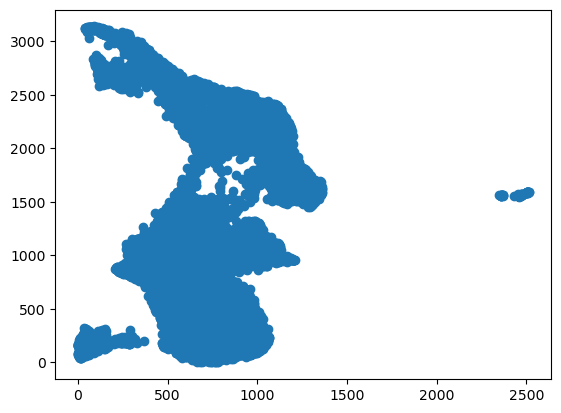

In [20]:
predicted_values = regressor.predict(feature_data)
# plot predicted values

plt.scatter(predicted_values[:,0], predicted_values[:,1])

In [21]:
feature_data

array([[17597.44347826,  1176.79130435,   160.7826087 , ...,
          704.26956522,   201.77391304,   853.14782609],
       [18031.08695652,  1125.2826087 ,   176.93478261, ...,
         1027.83695652,   387.5       ,   902.48913043],
       [ 8402.59677419,  1249.53225806,   156.9516129 , ...,
         1327.27419355,   289.08064516,   940.20967742],
       ...,
       [24690.94202899,  1173.76811594,   206.2173913 , ...,
          911.7826087 ,   271.4057971 ,   956.2173913 ],
       [21059.90322581,  1159.64516129,   224.3655914 , ...,
          935.08602151,   277.56989247,   879.67741935],
       [23099.34328358,  1175.65671642,   231.19402985, ...,
          560.91044776,   168.35820896,   844.91044776]])

In [22]:
# predict regressor 
predicted_values = regressor.predict(feature_data)
# plot predicted values



In [23]:
exemplar_df

,CellID,DNA_6,ELANE,CD57,CD45,DNA_7,CD11B,SMA,CD16,DNA_8,...,Eccentricity,Solidity,Extent,Orientation,UMAP_X,UMAP_Y,kmeans,agcluster,EEMB_x,EEMB_y
0,1,17597.443478,1176.791304,160.782609,703.991304,5866.643478,377.400000,245.260870,331.278261,6816.017391,...,0.295521,0.966387,0.798611,-1.104797,821.972412,778.844238,Kluster 7,Cluster 7,336.372019,1910.968537
1,2,18031.086957,1125.282609,176.934783,792.826087,11817.923913,910.304348,422.347826,646.923913,13424.717391,...,0.541562,0.948454,0.696970,-0.435290,509.592957,911.575134,Kluster 8,Cluster 3,1082.982972,2896.412217
2,3,8402.596774,1249.532258,156.951613,816.225806,5040.790323,1046.177419,487.854839,601.790323,5557.935484,...,0.496871,0.837838,0.563636,1.355995,1017.811462,1678.769043,Kluster 6,Cluster 8,583.642188,323.947450
3,4,22322.404412,1156.683824,187.330882,853.250000,13716.878676,816.955882,2187.911765,376.194853,15479.356618,...,0.805900,0.834356,0.537549,-0.709765,486.098480,484.259033,Kluster 4,Cluster 6,1797.930493,2785.830015
4,5,8101.017199,1570.628993,163.009828,318.027027,4959.896806,826.963145,361.771499,366.088452,5628.589681,...,0.678529,0.933486,0.707826,-0.719601,867.799133,1944.319092,Kluster 6,Cluster 8,594.190207,272.817062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,11166,14693.016949,1224.372881,208.853107,1071.937853,8231.203390,865.022599,1187.045198,379.988701,10322.225989,...,0.839933,0.917098,0.702381,-1.390099,571.490479,493.343750,Kluster 7,Cluster 7,482.865243,1996.896298
11166,11167,23067.893939,1217.439394,228.727273,1247.242424,13142.106061,775.621212,1038.151515,367.500000,12688.318182,...,0.606722,0.891892,0.660000,-0.387542,698.316101,468.275574,Kluster 4,Cluster 3,1628.840064,2833.308199
11167,11168,24690.942029,1173.768116,206.217391,973.942029,14485.637681,706.695652,1816.202899,353.681159,17806.826087,...,0.699592,0.920000,0.766667,0.774327,510.602600,446.750244,Kluster 1,Cluster 6,2169.361706,2407.385774
11168,11169,21059.903226,1159.645161,224.365591,1073.870968,12691.688172,745.096774,1143.000000,364.215054,15388.989247,...,0.467857,0.939394,0.845455,-1.296469,681.211914,485.209747,Kluster 4,Cluster 3,1598.257743,2926.824546


In [26]:
# # exemplar_df
# # rename agglomerative_cluster agglomerative
exemplar_df['cluster'] = agglomerative.labels_
# # drop agglomerative_cluster
exemplar_df = exemplar_df.drop(columns=['agcluster'])

In [27]:
exemplar_df

,CellID,DNA_6,ELANE,CD57,CD45,DNA_7,CD11B,SMA,CD16,DNA_8,...,Eccentricity,Solidity,Extent,Orientation,UMAP_X,UMAP_Y,kmeans,EEMB_x,EEMB_y,cluster
0,1,17597.443478,1176.791304,160.782609,703.991304,5866.643478,377.400000,245.260870,331.278261,6816.017391,...,0.295521,0.966387,0.798611,-1.104797,821.972412,778.844238,Kluster 7,336.372019,1910.968537,1
1,2,18031.086957,1125.282609,176.934783,792.826087,11817.923913,910.304348,422.347826,646.923913,13424.717391,...,0.541562,0.948454,0.696970,-0.435290,509.592957,911.575134,Kluster 8,1082.982972,2896.412217,1
2,3,8402.596774,1249.532258,156.951613,816.225806,5040.790323,1046.177419,487.854839,601.790323,5557.935484,...,0.496871,0.837838,0.563636,1.355995,1017.811462,1678.769043,Kluster 6,583.642188,323.947450,0
3,4,22322.404412,1156.683824,187.330882,853.250000,13716.878676,816.955882,2187.911765,376.194853,15479.356618,...,0.805900,0.834356,0.537549,-0.709765,486.098480,484.259033,Kluster 4,1797.930493,2785.830015,3
4,5,8101.017199,1570.628993,163.009828,318.027027,4959.896806,826.963145,361.771499,366.088452,5628.589681,...,0.678529,0.933486,0.707826,-0.719601,867.799133,1944.319092,Kluster 6,594.190207,272.817062,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11165,11166,14693.016949,1224.372881,208.853107,1071.937853,8231.203390,865.022599,1187.045198,379.988701,10322.225989,...,0.839933,0.917098,0.702381,-1.390099,571.490479,493.343750,Kluster 7,482.865243,1996.896298,3
11166,11167,23067.893939,1217.439394,228.727273,1247.242424,13142.106061,775.621212,1038.151515,367.500000,12688.318182,...,0.606722,0.891892,0.660000,-0.387542,698.316101,468.275574,Kluster 4,1628.840064,2833.308199,3
11167,11168,24690.942029,1173.768116,206.217391,973.942029,14485.637681,706.695652,1816.202899,353.681159,17806.826087,...,0.699592,0.920000,0.766667,0.774327,510.602600,446.750244,Kluster 1,2169.361706,2407.385774,3
11168,11169,21059.903226,1159.645161,224.365591,1073.870968,12691.688172,745.096774,1143.000000,364.215054,15388.989247,...,0.467857,0.939394,0.845455,-1.296469,681.211914,485.209747,Kluster 4,1598.257743,2926.824546,3


In [28]:
# exemplar_df
# drop these columns kmeans	agcluster	EEMB_x	EEMB_y
# exemplar_df = exemplar_df.drop(columns=['kmeans', 'agcluster', 'EEMB_x', 'EEMB_y'])

exemplar_df['agglomerative'] = agglomerative.labels_
# Save to parquet
exemplar_df.to_parquet("/Users/swarchol/Documents/exemplar_df.parquet", index=False)


# %%



In [29]:
exemplar_df.to_csv("/Users/swarchol/Documents/df.csv", index=False)

In [30]:
from ome_types import from_tiff
from tifffile import tiffcomment

# Read channel names from the original file
original_xml = from_tiff(image_path)
original_channel_names = [channel.name for channel in original_xml.images[0].pixels.channels]

# Read the hybrid file to update
hybrid_xml = from_tiff(OUTPUT_TIFF_PATH)

# Update channel names in the hybrid file
for i in range(len(hybrid_xml.images[0].pixels.channels)):
    if i < len(original_channel_names):
        hybrid_xml.images[0].pixels.channels[i].name = original_channel_names[i]

# Write the updated metadata back to the hybrid file
hybrid_ome_xml = hybrid_xml.to_xml()
# TIFF strings must be 7-bit ASCII
hybrid_ome_xml = hybrid_ome_xml.encode('utf-8')
tiffcomment(OUTPUT_TIFF_PATH, hybrid_ome_xml)

In [31]:
shap_parquet = np.abs(alphabetical_shap_values)
shap_parquet = shap_parquet.sum(axis=2)
shap_parquet.shape

(11170, 10)

In [32]:
alphabetical_shap_values.shape
shap_df = pd.DataFrame(shap_parquet, columns=alphabetical_features)
shap_df.to_parquet("/Users/swarchol/Documents/shap.parquet")

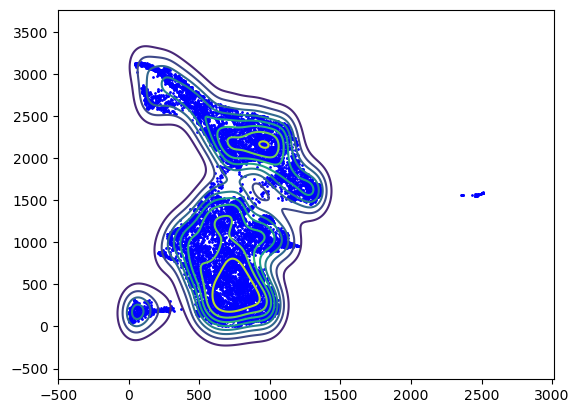

In [33]:
import scipy.stats as st

x = csv_df['UMAP_X']
y = csv_df['UMAP_Y']
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

# Expand the area to ensure contours are complete
xmin_expanded = xmin - (xmax - xmin) * 0.2  # 10% expansion on both sides
xmax_expanded = xmax + (xmax - xmin) * 0.2
ymin_expanded = ymin - (ymax - ymin) * 0.2
ymax_expanded = ymax + (ymax - ymin) * 0.2

# Peform the kernel density estimate with expanded area
xx, yy = np.mgrid[xmin_expanded:xmax_expanded:1024j, ymin_expanded:ymax_expanded:1024j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = st.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)
import matplotlib.contour as mcontour
fig, ax = plt.subplots()
contours = ax.contour(xx, yy, f, filled=False, levels=np.linspace(f.min(), f.max(), 10))
# plot the scatterplot of the points
plt.scatter(x, y, c='blue', s=1)
contour_lines = []
contours.allsegs
for seg in contours.allsegs:
    for line in seg:
        contour_lines.append(line.tolist())

# Pickle the contour_lines
with open('/Users/swarchol/Documents/contour.pkl', 'wb') as f:
    pickle.dump(contour_lines, f)

In [34]:
import json
# contour_lines
# save to json
with open('/Users/swarchol/Documents/contour.json', 'w') as f:
    json.dump(contour_lines, f)
